## Structural Identifiability Analysis for Case Study 1 (With Parameter Fixing)

## Install & import

In [1]:
!pip install casadi --quiet
!pip install pymoo --quiet
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.io import loadmat
from scipy.linalg import svd
from pymoo.core.problem import Problem
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
from pymoo.termination import get_termination
import warnings
import time
from pymoo.core.sampling import Sampling
warnings.filterwarnings("ignore")
from scipy.io import loadmat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 6.0 MB/s eta 0:00:00


## Fixing Parameters: Genetic Algorithm application

In [ ]:
# === PART 1: Dimensions and Parameters ===
nx = 5
nth = 14
Nt = 450
Tf = 161
t_eval = np.linspace(0, Tf, Nt)
param_names = [f"θ{i+1}" for i in range(nth)]
x0_val = np.array([0.2, 0.1737, 115.55, 100.94, 0.0])
dx0_val = np.zeros((nx, nth))

# === PART 2: Model Functions ===
def build_model(free_idx, theta_nom):
    n_free = len(free_idx)
    theta_free = ca.MX.sym("theta", n_free)

    # Reconstruct full parameter vector (fixed params as constants)
    theta_total = []
    theta_free_list = []
    free_idx_map = {}

    for i in range(len(theta_nom)):
        if i in free_idx:
            th_i = ca.MX.sym(f"th{i}", 1)
            theta_total.append(th_i)
            theta_free_list.append(th_i)
            free_idx_map[i] = len(theta_free_list) - 1
        else:
            theta_total.append(ca.MX(theta_nom[i]))

    theta_free = ca.vertcat(*theta_free_list)

    x = ca.MX.sym("x", nx)
    U1 = ca.MX.sym("U1")  # Temperature (K)
    U2 = ca.MX.sym("U2")  # Thermal death indicator

    th = theta_total
    (th1, th2, th3, th4, th5, th6, th7, th8, th9, th10, th11, th12, th13, th14) = th

    xdot = ca.vertcat(
        th1 * ca.exp(59453*(U1 - 300)/(300*8.314*U1)) * (x[1]/(x[1] + th4 * ca.exp(46055*(U1 - 293.15)/(293.15*8.314*U1)))) * x[0]
        - U2 * th9 * ca.exp(0.0415 * x[4] + 130000*(U1 - 305.65)/(305.65*8.314*U1)) * x[0],

        -th1 * ca.exp(59453*(U1 - 300)/(300*8.314*U1)) * (x[1]/(x[1] + th4 * ca.exp(46055*(U1 - 293.15)/(293.15*8.314*U1)))) * (x[0]/th10),

        -((th1 * ca.exp(59453*(U1 - 300)/(300*8.314*U1)) * (x[1]/(x[1] + th4 * ca.exp(46055*(U1 - 293.15)/(293.15*8.314*U1)))) / th11)
          + (th2 * ca.exp(11000*(U1 - 296.15)/(296.15*8.314*U1)) * (x[2]/(x[2] + th5 * ca.exp(46055*(U1 - 293.15)/(293.15*8.314*U1))))
             * (th8 * ca.exp(46055*(U1 - 293.15)/(293.15*8.314*U1)) / (x[4] + th8 * ca.exp(46055*(U1 - 293.15)/(293.15*8.314*U1)))) / th13)
          + 0.01 * ca.exp(37681*(U1 - 293.3)/(293.3*8.314*U1)) * (x[2]/(x[2] + x[3]))) * x[0],

        -((th1 * ca.exp(59453*(U1 - 300)/(300*8.314*U1)) * (x[1]/(x[1] + th4 * ca.exp(46055*(U1 - 293.15)/(293.15*8.314*U1)))) / th12)
          + (th3 * ca.exp(11000*(U1 - 296.15)/(296.15*8.314*U1)) * (x[3]/(x[3] + th6 * ca.exp(46055*(U1 - 293.15)/(293.15*8.314*U1))))
             * (th7 * ca.exp(46055*(U1 - 293.15)/(293.15*8.314*U1)) / (x[2] + th8 * ca.exp(46055*(U1 - 293.15)/(293.15*8.314*U1))))
             * (th8 * ca.exp(46055*(U1 - 293.15)/(293.15*8.314*U1)) / (x[4] + th8 * ca.exp(46055*(U1 - 293.15)/(293.15*8.314*U1)))) / th14)
          + 0.01 * ca.exp(37681*(U1 - 293.3)/(293.3*8.314*U1)) * (x[3]/(x[2] + x[3]))) * x[0],

        (th2 * ca.exp(11000*(U1 - 296.15)/(296.15*8.314*U1)) * (x[2]/(x[2] + th5 * ca.exp(46055*(U1 - 293.15)/(293.15*8.314*U1))))
         * (th8 * ca.exp(46055*(U1 - 293.15)/(293.15*8.314*U1)) / (x[4] + th8 * ca.exp(46055*(U1 - 293.15)/(293.15*8.314*U1))))
         + th3 * ca.exp(11000*(U1 - 296.15)/(296.15*8.314*U1)) * (x[3]/(x[3] + th6 * ca.exp(46055*(U1 - 293.15)/(293.15*8.314*U1))))
         * (th7 * ca.exp(46055*(U1 - 293.15)/(293.15*8.314*U1)) / (x[2] + th8 * ca.exp(46055*(U1 - 293.15)/(293.15*8.314*U1))))
         * (th8 * ca.exp(46055*(U1 - 293.15)/(293.15*8.314*U1)) / (x[4] + th8 * ca.exp(46055*(U1 - 293.15)/(293.15*8.314*U1))))) * x[0]
    )

    dfdx = ca.jacobian(xdot, x)
    dfdth = ca.jacobian(xdot, theta_free)

    f_fun = ca.Function("f", [x, U1, U2, theta_free], [xdot])
    dfdx_fun = ca.Function("dfdx", [x, U1, U2, theta_free], [dfdx])
    dfdth_fun = ca.Function("dfdth", [x, U1, U2, theta_free], [dfdth])

    return f_fun, dfdx_fun, dfdth_fun

# === PART 3: Simulation with Operational Input and Sensitivities ===
def simulate_once(TU, f_fun, dfdx_fun, dfdth_fun, theta_val):
    x_aug0 = np.concatenate([x0_val, dx0_val[:, :len(theta_val)].flatten()])
    def rhs(t, x_aug):
        x = x_aug[:nx]
        dx_dth = x_aug[nx:].reshape((nx, len(theta_val)))
        interp_temp = interp1d(TU[:, 0], TU[:, 1], kind='nearest', fill_value="extrapolate")
        U1 = float(interp_temp(t))
        Td = -0.0001*x[4]**3 + 0.0049*x[4]**2 - 0.1279*x[4] + 315.89
        U2 = 1.0 if U1 >= Td else 0.0
        f_val = np.array(f_fun(x, U1, U2, theta_val)).flatten()
        A = np.array(dfdx_fun(x, U1, U2, theta_val))
        B = np.array(dfdth_fun(x, U1, U2, theta_val))
        d_dxdt = A @ dx_dth + B
        return np.concatenate([f_val, d_dxdt.flatten()])

    sol = solve_ivp(rhs, [0, Tf], x_aug0, t_eval=t_eval, method="BDF", rtol=1e-12, atol=1e-12)
    x_out = sol.y[:nx, :].T
    dx_dth_out = sol.y[nx:, :].T.reshape(len(t_eval), nx, len(theta_val))
    return x_out, dx_dth_out

# === PART 4: Compute Relative Sensitivities ===
def compute_dydth(x_out, dx_dth_out, theta_nom, free_idx):
    ny = 3  # observables: N, G, F = x[1], x[2], x[3]
    Nt = x_out.shape[0]
    dydth = np.zeros((Nt * ny, len(free_idx)))
    dydth_rel = np.zeros_like(dydth)
    y_out = np.zeros((Nt, ny))
    for i in range(Nt):
        y_out[i] = x_out[i, 1:4]
        for j in range(ny):
            dydth[i * ny + j, :] = dx_dth_out[i, j + 1, :]
            if y_out[i, j] != 0:
                dydth_rel[i * ny + j, :] = dydth[i * ny + j, :] * theta_nom[free_idx] / y_out[i, j]
    return dydth, dydth_rel, y_out
# === PART 5: Optimization Class ===
class IdentifiabilityProblem(Problem):
    def __init__(self, TU, theta_nom, sigma_threshold=1e-3, NExp=2):
        super().__init__(n_var=len(theta_nom), n_obj=1, xl=0, xu=1, type_var=int)
        self.TU = TU
        self.theta_nom = theta_nom
        self.sigma_threshold = sigma_threshold
        self.NExp = NExp
        self.nth = len(theta_nom)

        # 🧠 Track successful fixed parameter combinations
        self.successful_combinations = set()
        self.cache = set()
        self.sigma_log = []

    def is_pruned_combination(self, fixed_idx):
        """
        Prune any combination with more fixed parameters than a previously successful one.
        """
        return any(len(fixed_idx) >= len(success) for success in self.successful_combinations)

    def _evaluate(self, X, out, *args, **kwargs):
        F = np.full((X.shape[0],), 1e6)

        for i in range(X.shape[0]):
            mask = tuple(int(val) for val in X[i])
            mask_bool = np.array(mask).astype(bool)
            free_idx = [j for j in range(self.nth) if mask_bool[j]]
            fixed_idx = [j for j in range(self.nth) if not mask_bool[j]]

            print(f"\n🧪 Experiment {i+1}: fixing {[f'θ{j+1}' for j in fixed_idx]}")
            print(f"   ↳ Free: {[f'θ{j+1}' for j in free_idx]}")

            if self.is_pruned_combination(fixed_idx):
                print("⏭️ Pruned combination")
                continue
            if mask in self.cache:
                F[i] = 1e7
                print(f"🔁 Individual {i} already evaluated. Skipping.")
                continue
            self.cache.add(mask)

            try:
                f_fun, dfdx_fun, dfdth_fun = build_model(free_idx, self.theta_nom)
                theta_nom_sub = self.theta_nom[free_idx]
                theta_low = 0.9 * theta_nom_sub
                theta_high = 1.1 * theta_nom_sub

                sigma_vals = []
                for k in range(self.NExp):
                    theta_sample = theta_nom_sub if k == 0 else np.random.uniform(theta_low, theta_high)
                    try:
                        x_out, dx_dth_out = simulate_once(self.TU, f_fun, dfdx_fun, dfdth_fun, theta_sample)
                        y = np.stack([x_out[:, 1], x_out[:, 2], x_out[:, 3]], axis=1)
                        dydth = dx_dth_out[:, 1:4, :]
                        dydth_rel = dydth * theta_nom_sub / y[:, :, np.newaxis]
                        dydth_rel = dydth_rel.reshape(-1, dydth_rel.shape[-1])
                        _, S, _ = svd(dydth_rel, full_matrices=False)
                        sigma_vals.append(np.min(S))
                    except Exception as e:
                        print(f"⚠️ Internal error in MC {k}: {e}")
                        sigma_vals.append(0.0)

                sigma_min = np.min(sigma_vals)
                self.sigma_log.append((i, sigma_min))

                # ⚖️ Objective: balance between minimal fixing and identifiability
                if sigma_min >= self.sigma_threshold:
                    F[i] = len(fixed_idx) - 0.01 * sigma_min  # Small bonus for good sigma
                    self.successful_combinations.add(tuple(sorted(fixed_idx)))
                    print(f"✅ σ_min = {sigma_min:.2e} ≥ threshold → valid combination")
                else:
                    F[i] = len(fixed_idx) + 10 - sigma_min  # Hard penalty for low sigma
                    print(f"🔴 σ_min = {sigma_min:.2e} < threshold")

            except Exception as e:
                print(f"❌ Error in evaluation {i}: {e}")
                self.sigma_log.append((i, None))

        out["F"] = F
# === PART 6: Run Optimization ===
data = loadmat('Operational_Data.mat')
TU = data['Time_Temp_Pairs']
TU[:, 1] += 273.15  # Convert °C to K

theta_nom = np.array([0.18, 0.225, 0.225, 0.01, 7.5, 7.5, 0.1737/4, 40.0, 0.00044,
                      19.69, 1.60, 1.60, 0.49, 0.49])

# Custom sampling: ensures the first individual has all parameters free
class CustomSampling(Sampling):
    def _do(self, problem, n_samples, **kwargs):
        pop = np.random.randint(0, 2, size=(n_samples - 1, problem.n_var), dtype=int)
        start = np.ones(problem.n_var, dtype=int).reshape(1, -1)  # all parameters free
        return np.vstack([start, pop])

# Define problem
problem = IdentifiabilityProblem(TU=TU, theta_nom=theta_nom)

# GA algorithm with custom binary sampling
algorithm = GA(
    pop_size=50,
    sampling=CustomSampling(),
    eliminate_duplicates=True
)

termination = get_termination("n_gen", 10)
start_time = time.perf_counter()
res = minimize(
    problem,
    algorithm,
    termination,
    seed=42,
    verbose=True
)
elapsed_time = time.perf_counter() - start_time
print(f"\nSimulation time: {elapsed_time:.3e} s.")
# Output best result
best = res.X
free_idx = [i for i in range(len(theta_nom)) if best[i] == 1]
print("\n✅ Best combination found (free parameters):", free_idx)




🧪 Experiment 1: fixing []
   ↳ Free: ['θ1', 'θ2', 'θ3', 'θ4', 'θ5', 'θ6', 'θ7', 'θ8', 'θ9', 'θ10', 'θ11', 'θ12', 'θ13', 'θ14']
🔴 σ_min = 1.27e-18 < threshold

🧪 Experiment 2: fixing ['θ1', 'θ3', 'θ4', 'θ5', 'θ7', 'θ8', 'θ9', 'θ11', 'θ12', 'θ13', 'θ14']
   ↳ Free: ['θ2', 'θ6', 'θ10']


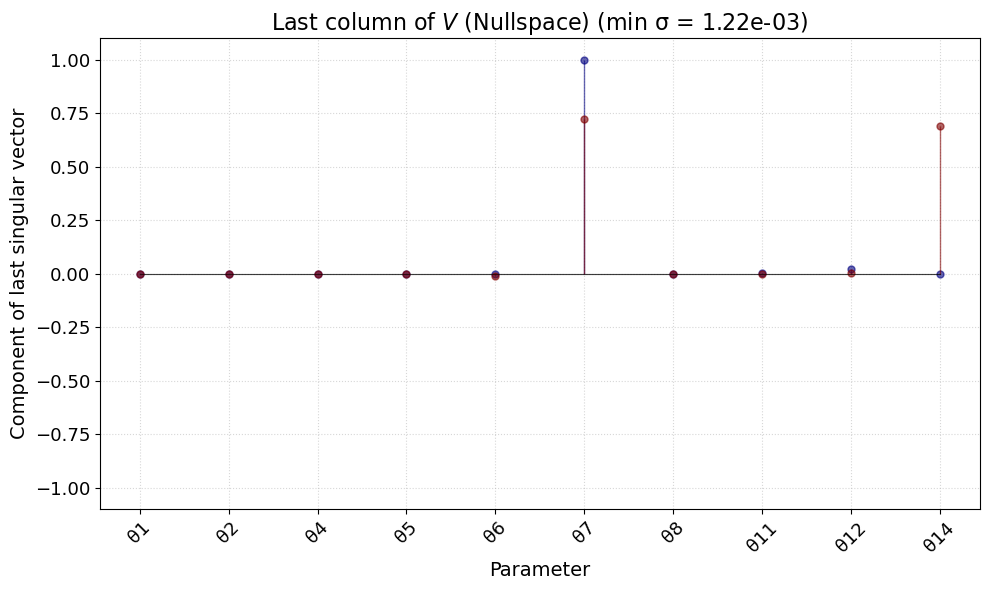

In [ ]:
colors = plt.cm.jet(np.linspace(0, 1, problem.NExp))
x_vals = np.arange(problem.nth)
plt.figure(figsize=(10, 6))

# Rebuild model and simulate with best free indices
free_idx = [i for i in range(len(theta_nom)) if best[i] == 1]
f_fun, dfdx_fun, dfdth_fun = build_model(free_idx, theta_nom)
theta_nom_sub = theta_nom[free_idx]
theta_low = 0.9 * theta_nom_sub
theta_high = 1.1 * theta_nom_sub

V_last_cols = []

for k in range(problem.NExp):
    theta_sample = theta_nom_sub if k == 0 else np.random.uniform(theta_low, theta_high)
    x_out, dx_dth_out = simulate_once(TU, f_fun, dfdx_fun, dfdth_fun, theta_sample)
    dydth, dydth_rel, _ = compute_dydth(x_out, dx_dth_out, theta_nom, free_idx)
    _, S, Vh = svd(dydth_rel, full_matrices=False)
    v_last = Vh[-1]
    V_last_cols.append(v_last)

    # Plot
    markerline, stemlines, baseline = plt.stem(x_vals[:len(free_idx)], v_last,
        linefmt='-', markerfmt='o', basefmt='k-')
    plt.setp(markerline, color=colors[k], markersize=5, alpha=0.6)
    plt.setp(stemlines, color=colors[k], linewidth=1, alpha=0.6)
    plt.setp(baseline, color='k', linewidth=0.8, alpha=0.5)

param_names_plot = [param_names[i] for i in free_idx]
plt.xticks(np.arange(len(free_idx)), param_names_plot, fontsize=13, rotation=45)
plt.yticks(fontsize=13)
plt.title(f"Last column of $V$ (Nullspace) (min σ = {np.min(S):.2e})", fontsize=16)
plt.xlabel("Parameter", fontsize=14)
plt.ylabel("Component of last singular vector", fontsize=14)
plt.ylim(-1.1, 1.1)
plt.grid(True, linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()


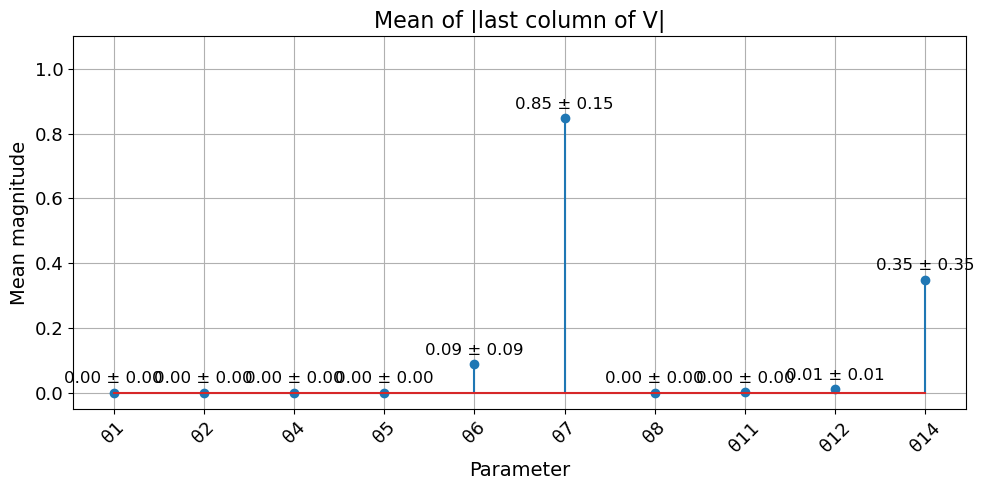

In [ ]:
V_last_cols_array = np.array(V_last_cols)
mean_v = np.mean(np.abs(V_last_cols_array), axis=0)
std_v = np.std(np.abs(V_last_cols_array), axis=0)

plt.figure(figsize=(10, 5))
plt.stem(mean_v)
for i in range(len(free_idx)):
    plt.text(i, mean_v[i] + 0.02, f"{mean_v[i]:.2f} ± {std_v[i]:.2f}",
             ha='center', va='bottom', fontsize=12)

plt.xticks(np.arange(len(free_idx)), param_names_plot, fontsize=13, rotation=45)
plt.yticks(fontsize=13)
plt.title("Mean of |last column of V|", fontsize=16)
plt.xlabel("Parameter", fontsize=14)
plt.ylabel("Mean magnitude", fontsize=14)
plt.ylim(-0.05, 1.1)
plt.grid(True)
plt.tight_layout()
plt.show()


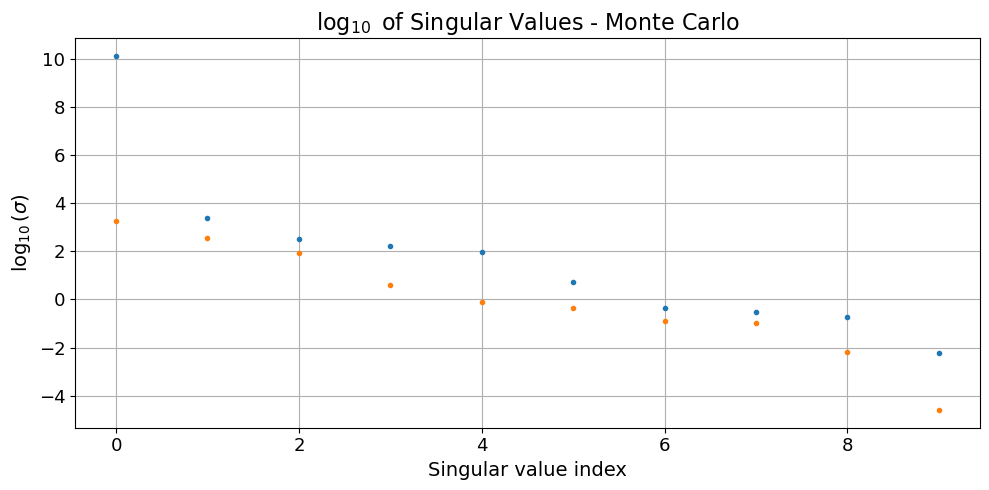

In [ ]:
SingularValues = []

for k in range(problem.NExp):
    theta_sample = theta_nom_sub if k == 0 else np.random.uniform(theta_low, theta_high)
    x_out, dx_dth_out = simulate_once(TU, f_fun, dfdx_fun, dfdth_fun, theta_sample)
    dydth, dydth_rel, _ = compute_dydth(x_out, dx_dth_out, theta_nom, free_idx)
    _, S, _ = svd(dydth_rel, full_matrices=False)
    SingularValues.append(S)

SingularValues = np.array(SingularValues)

plt.figure(figsize=(10, 5))
for k in range(problem.NExp):
    plt.plot(np.log10(SingularValues[k]), '.', label=f"Exp {k+1}")
plt.title(r"$\log_{10}$ of Singular Values - Monte Carlo", fontsize=16)
plt.xlabel("Singular value index", fontsize=14)
plt.ylabel(r"$\log_{10}(\sigma)$", fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True)
plt.tight_layout()
plt.show()
